# Uniaxial Tension - Elasticity, Physics Informed Neural Network

Thomas Allard and Samantha Walker

In [40]:
#Imports
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt
import scipy.io
import netCDF4
import xarray as xr

import os

In [41]:
# Specify parameters and things
mode = 'train'   # 'test' to load PINN weights from previously trained model
                # 'train' to train a new model

#trained_file = 'trained-navier-stokes.hdf5'
data_file = '../abaqus/final_elastic/elastic_cdf.nc'

In [42]:
# load in data_file as xarray DataSet
set = xr.open_dataset(data_file)

In [58]:
# Load in displacements and create an ndarray
disp_x=set.sel(field='ux').to_array()
disp_y=set.sel(field='uy').to_array()
disps=np.dstack([disp_x,disp_y])

In [67]:
# Load in grid
def file2array(file):
    # load in each line of data as array
    with open(file, 'r') as f:
        line_string = f.read().splitlines()
    
    # loop through the lines from the file, split, and append to list
    list = []
    timestamp = 0 # default 
    for i, line in enumerate(line_string):
        list.append(line.split())

    # convert list to an array of type float64
    array = np.asarray(list, dtype=np.float64)

    return(array)
node_file = '../abaqus/final_elastic/nodes.txt'
nodal_coordinates = file2array(node_file)
grid = nodal_coordinates[:,1:3]

array([[    0.       , -1500.       ],
       [   66.6666641, -1500.       ],
       [  133.333328 , -1500.       ],
       ...,
       [ 2866.66675  ,  1500.       ],
       [ 2933.33325  ,  1500.       ],
       [ 3000.       ,  1500.       ]])

In [44]:
# Extract time and put in an array
time = []
for DataArray in set.values():
    time.append(DataArray.attrs['time'])

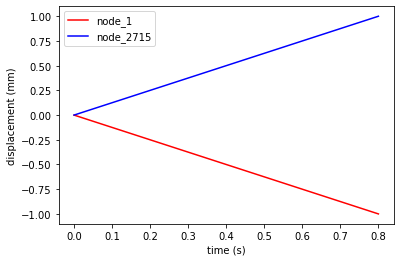

In [57]:
# Check that data loaded in correctly by plotting disp_y for node 1 (bottom left) and node 2715 (top left)
plt.plot(time,set.sel(field='uy',node='1').to_array(),   color='red',label='node_1')
plt.plot(time,set.sel(field='uy',node='2715').to_array(),color='blue',label='node_2715')
plt.xlabel('time (s)')
plt.ylabel('displacement (mm)')
plt.legend()
plt.show()

In [ ]:
# define function for subsampling data
def PrepareData(data, grid, num_data, data_file, random=True):
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    #data = scipy.io.loadmat(data_file)
    
    # will want to change these to correspond to our input variables
    #U_star = data['U_star'] # N x 2 x T
    ## displacements -> U_
    disp_x=set.sel(field='ux').to_array()
    disp_y=set.sel(field='uy').to_array()
    U_star=np.dstack([disp_x,disp_y])
    
    
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = grid
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T
    
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)
